In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install evaluate
!pip install bert-score==0.3.13
!pip install rouge-score==0.1.2
!pip install demoji

In [ ]:
!pip install sklearn
!pip install spacy scipy fast_pagerank
!pip install nltk
!pip install sentence_transformers

In [ ]:
import os
import pathlib
from typing import TypeVar, Dict, List, Tuple
from statistics import mean
from tqdm import tqdm
from evaluate import load
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import demoji
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product
from statistics import mean

from scipy import sparse
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from sentence_transformers import SentenceTransformer, util


pd.set_option('display.max_colwidth', None)

In [ ]:
test_df = pd.read_csv(r'/content/gdrive/MyDrive/Πτυχιακή/Code/Experiments_Meltemi/train_dev_test_dataset/arguments_human_translated_test.csv', index_col=None)

In [ ]:
test_df.head()

,arg_id,topic,stance,argument
0,arg_4_0,Θα πρέπει να καταργηθεί η μαθητική στολή στα σχολεία,-1,"το να φορούν οι μαθητές στολή μπορεί να μειώσει τον σχολικό εκφοβισμό, έτσι ώστε εκείνοι που δεν έχουν προσωπικό στυλ ή χρήματα να μην ξεχωρίζουν από το σύνολο."
1,arg_4_1,Θα πρέπει να καταργηθεί η μαθητική στολή στα σχολεία,-1,είναι ένας καλός τρόπος να ενσταλλάξεις την πειθαρχία
2,arg_4_2,Θα πρέπει να καταργηθεί η μαθητική στολή στα σχολεία,-1,"η αγορά μαθητικής στολής είναι μια πιο φθηνή λύση, ιδιαίτερα για τους γονείς που δυσκολεύονται οικονομικά."
3,arg_4_3,Θα πρέπει να καταργηθεί η μαθητική στολή στα σχολεία,-1,"ένα από τα οφέλη της μαθητικής στολής είναι ότι οι οικογένειες εξοικονομούν χρήματα, γιατί περιορίζουν το ποσό που ξοδεύουν για τον ρουχισμό των παιδιών τους"
4,arg_4_4,Θα πρέπει να καταργηθεί η μαθητική στολή στα σχολεία,-1,"έρευνες δείχνουν ότι στα σχολεία εκείνα ανα τον κόσμο, όπου η μαθητική σχολή είναι υποχρεωτική, οι μαθητές είναι πιο πειθαρχημένοι και συγκεντρωμένοι"


In [ ]:

test_df["argument"].dropna(inplace=True)


In [ ]:
test_df=test_df.dropna()

In [ ]:
test_df

,arg_id,argument,topic,stance
0,arg_0_0,"Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,-1
1,arg_0_1,"Οι παιδικοί εμβολιασμοί ρουτίνας δεν θα πρέπει να είναι υποχρεωτικοί, καθώς τα παιδιά μπορεί να μην είναι σε θέση να αντέξουν τις επιπτώσεις τους.",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,-1
2,arg_0_2,Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες,Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,-1
3,arg_0_3,"Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,-1
4,arg_0_4,"Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας.",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,-1
...,...,...,...,...
718,arg_2_205,οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα,Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,1
719,arg_2_206,όλοι θέλουμε το αμερικανικό όνειρο. είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία,Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,1
720,arg_2_207,"ναι, για την οικονομική και εργασιακή της σταθερότητα",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,1
721,arg_2_208,"ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,1


In [ ]:
test_df["argument"].isna().sum()

0

#Apply sentence tokenization with nltk

In [ ]:
test_df["sents"] =  test_df.apply(lambda x : nltk.tokenize.sent_tokenize(x["argument"]), axis=1)

In [ ]:
test_df.columns

Index(['arg_id', 'argument', 'topic', 'stance', 'sents'], dtype='object')

In [ ]:
#We try a multilingual model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", trust_remote_code=True)
def gen_match_matrix(model, sents, min_match_score=0.8):
    sents1 = [x for x in sents]
    sents1_embeddings = model.encode(sents1)
    sim_matrix = cosine_similarity(sents1_embeddings, sents1_embeddings)
    super_threshold_indices = sim_matrix < min_match_score  # the pairs with the highest number of comparisons that pass a minimum threshold (0.8) are KP candidates
    sim_matrix[super_threshold_indices] = 0
    #print(sim_matrix)
    return sim_matrix

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**Pagerank** and generating top X potential kp on the full data
Note: Topics are Just geographically not on a cluster => matching might be required

Calculate the cosine similarity matrix between all encoded sentences of the arguments

In [ ]:
def filter_ranked_list(ranked_sents, model, min_match=0.4, N=3):
    ranked_sents = [x[0] for x in ranked_sents]
    filtered_sents = []
    for i, s in enumerate(ranked_sents):
        if len(filtered_sents) >= N or len(filtered_sents) >= len(ranked_sents):
            break
        if len(filtered_sents) == 0:
            filtered_sents.append(s)
            # print('FFFF ' , s)
        else:
            matching_scores = gen_match_matrix(model, [s] + filtered_sents)  #compare each sentence with the ones already in the filtered sents list. e'g if the second sentence in the iteration has a maximum similary score higher that .8 ,
            #then this sentence will be too similar with the alredy on the filtered sents list and there will be two sentence that talk about the same thing on the candidates (min_match can be a tunable parameter!! based on the results of the
            # similary matrix)
            max_sim = np.max(matching_scores[0][1:])
            #print("matching_scores:",matching_scores)
            if max_sim < min_match:
                # print('SSSS ' , s)
                filtered_sents.append(s)

        # print(min_match)

    return filtered_sents

In [ ]:
def apply_page_rank(sentences, p=0.85, min_match_score=0.8, min_len=5, max_len=23):
    cand_sents = [x for x in sentences if len(x.split()) < max_len and len(x.split()) > min_len]
    if len(cand_sents) == 0:
        #print('empty')
        return []

    cands_matching_mat = gen_match_matrix(model, cand_sents, min_match_score=min_match_score)
    pr = pagerank(cands_matching_mat, p=p)
    ranked_candidates = list(zip(cand_sents, pr))
    return sorted(ranked_candidates, key=lambda x: -x[1])

In [ ]:
topics = []
stances = []
ranked_sents_per_topic = []
ranked_kps_per_topic = []

for i, row in test_df.iterrows():
    # Apply page rank on the sentences
    ranked_sents = apply_page_rank(row['sents'], p=0.85, min_match_score=0.8)
    ranked_sents_per_topic.append(ranked_sents)

    # Filter the ranked sentences to get key phrases
    ranked_kps = filter_ranked_list(ranked_sents, model, min_match=0.4, N=2)
    ranked_kps_per_topic.append(ranked_kps)

    # Append the topic and stance
    topics.append(row["topic"])
    stances.append(row["stance"])

# Create the DataFrame including 'stance'
results_df = pd.DataFrame({
    "ranked_sents": ranked_sents_per_topic,
    "topic": topics,
    "ranked_kps": ranked_kps_per_topic,
    "stance": stances  # Add the stance column
})



In [ ]:
results_df

,ranked_sents,topic,ranked_kps,stance
0,"[(Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό]",-1
1,[],Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,[],-1
2,"[(Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,[Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες],-1
3,"[(Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά]",-1
4,"[(Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας., 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας.]",-1
...,...,...,...,...
718,"[(οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,[οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα],1
719,"[(είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,[είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία],1
720,"[(ναι, για την οικονομική και εργασιακή της σταθερότητα, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"[ναι, για την οικονομική και εργασιακή της σταθερότητα]",1
721,"[(ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"[ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο]",1


In [ ]:
res_cleaned= results_df.dropna()

In [ ]:
res_cleaned=res_cleaned[res_cleaned['ranked_sents'].map(lambda d: len(d)) > 0]

In [ ]:
res_cleaned

,ranked_sents,topic,ranked_kps,stance
0,"[(Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό]",-1
2,"[(Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,[Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες],-1
3,"[(Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά, 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά]",-1
4,"[(Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας., 1.0)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας.]",-1
5,"[(Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα., 0.5), (Αφήστε τα παιδιά να αποφασίσουν μόνα τους, αν θέλουν να εμβολιαστούν., 0.5)]",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"[Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα., Αφήστε τα παιδιά να αποφασίσουν μόνα τους, αν θέλουν να εμβολιαστούν.]",-1
...,...,...,...,...
718,"[(οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,[οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα],1
719,"[(είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,[είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία],1
720,"[(ναι, για την οικονομική και εργασιακή της σταθερότητα, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"[ναι, για την οικονομική και εργασιακή της σταθερότητα]",1
721,"[(ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο, 1.0)]",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"[ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο]",1


Explode from list and set to a string. This is needed to be able to perform the grouping correctly



In [ ]:
res_cleaned=res_cleaned.explode("ranked_sents")

In [ ]:
res_cleaned=res_cleaned.explode("ranked_kps")

In [ ]:
res_cleaned

,ranked_sents,topic,ranked_kps,stance
0,"(Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό",-1
2,"(Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες,-1
3,"(Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά",-1
4,"(Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας., 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας.",-1
5,"(Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα., 0.5)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα.",-1
...,...,...,...,...
718,"(οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα,1
719,"(είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία,1
720,"(ναι, για την οικονομική και εργασιακή της σταθερότητα, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"ναι, για την οικονομική και εργασιακή της σταθερότητα",1
721,"(ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο",1


In [ ]:
res_cleaned.iloc[0,2]

'Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό'

#Drop duplicate keypoints from the ranked kps column

In [ ]:
res_cleaned.drop_duplicates(subset=['ranked_kps'])

,ranked_sents,topic,ranked_kps,stance
0,"(Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Οι εμβολιασμοί ρουτίνας δεν είναι απαραίτητοι στα παιδιά, καθώς αυτά δεν διαδίδουν τον ιό",-1
2,"(Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,Οι εμβολιασμοί ρουτίνας των παιδιών δεν χρειάζεται να είναι απαραίτητοι καθώς τα παιδιά δεν μπορούν να κολλήσουν ασθένειες,-1
3,"(Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά, 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Ένα εμβόλιο, το οποίο δεν έχει ελεγχθεί επαρκώς και του οποίου οι επιπτώσεις δεν είναι γνωστές, δεν ενδείκνυται για τα παιδιά",-1
4,"(Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας., 1.0)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Εφόσον τα εμβόλια φέρουν επιπτώσεις, δεν μπορούν να καθίστανται υποχρεωτικά για τα παιδιά μας.",-1
5,"(Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα., 0.5)",Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί,"Ο παιδικός εμβολιασμός δεν είναι απαραίτητος και δεν θα πρέπει να είναι υποχρεωτικός, γιατί τα εμβόλια είναι ένα ψέμα.",-1
...,...,...,...,...
718,"(οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,οι ΗΠΑ είναι μια εξαιρετική χώρα για να ζει κανείς και έχει να προσφέρει υπέροχα πράγματα,1
719,"(είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,είναι η καλύτερη χώρα στον κόσμο χωρίς αμφιβολία,1
720,"(ναι, για την οικονομική και εργασιακή της σταθερότητα, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"ναι, για την οικονομική και εργασιακή της σταθερότητα",1
721,"(ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο, 1.0)",Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς,"ναι, είναι η καλύτερη χώρα για να ζήσει κάποιος το αμερικανικό όνειρο",1


In [ ]:
len(res_cleaned['topic'].unique())  #how many unique topics ar there in my dataset?

3

In [ ]:
res_cleaned[["ranked_sents", "topic","ranked_kps","stance"]] = res_cleaned[["ranked_sents", "topic","ranked_kps","stance"]].astype(str)

We join all arguments belonging to the same topic by a unique token ";" not
present in the initial set to be able to resplit at a later point

In [ ]:
test_df = res_cleaned.groupby(['topic', 'stance'])['ranked_kps'].apply(';'.join).reset_index()

In [ ]:
test_df.head(10)

topic  \
0                                       Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς   
1                                       Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς   
2               Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί   
3               Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί   
4  Οι πλατφόρμες κοινωνικής δικτύωσης θα πρέπει να ρυθμίζονται από την κυβέρνηση   
5  Οι πλατφόρμες κοινωνικής δικτύωσης θα πρέπει να ρυθμίζονται από την κυβέρνηση   

  stance  \
0     -1   
1      1   
2     -1   
3      1   
4     -1   
5      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

**Example for just one instance**


In [ ]:
#apply page rank on section

print("topic:\n",test_df.iloc[1,0])
print("stance:\n",test_df.iloc[1,1])
list_df= test_df.iloc[1,2].split(';')
list_df=list(dict.fromkeys(list_df))
print("arguments:\n",list_df)

topic:
 Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς
stance:
 1
arguments:
 ['Εκτός από την ποικιλομορφία των ανθρώπων, οι Ηνωμένες Πολιτείες διαθέτουν και ένα ποικίλο φυσικό τοπίο', 'Η Αμερική είναι μια χώρα με πολλές ευκαιρίες για ανάπτυξη.', 'Είμαστε ένα ισχυρό έθνος που ενώνεται κάτω από τους ναούς στους οποίους ιδρύθηκε', 'Η Αμερική είναι ένα ελεύθερο έθνος όπου δουλεύοντας σκληρά, μπορείς να ζήσεις το Αμερικανικό όνειρο', 'Παρά τους υψηλούς φόρους, η ζωή στις Ηνωμένες Πολιτείες είναι καλή', 'Δεν θα την άλλαζα με τίποτα', 'Για τους ανθρώπους και τον πολιτισμό της είναι μια εξαιρετική χώρα να ζει κανείς.', 'Εξαιρετική χώρα, όπου κυνηγώντας το Αμερικανικό Όνειρο θα βρει κανείς μια πολύ καλή ποιότητα ζωής.', 'Η ζωή στον Ηνωμένες Πολιτείες αποτελεί στόχο για πολλούς ανθρώπους στον κόσμο.', 'Για μένα θα ήταν τέλειο να ζήσω εδώ, αφού το κλίμα είναι εξαιρετικό, και οι άνθρωποι είναι τόσο καλοί', 'Καταρχάς, οι Ηνωμένες Πολιτείες είναι μια τόσο μεγάλη χώρα και μεγάλη χώρα σημαίνει περισσότερη 

In [ ]:
print(len(set(list_df)))
print(len(list_df))

129
129


In [ ]:
#PR on topic:  Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς
# 7 KP for this section make a len and depend on it given the number of wished Kp size
ranked_sents_topic1 = apply_page_rank(list_df, p=0.85, min_match_score=0.8)
ranked_kps_topic1 = filter_ranked_list(ranked_sents_topic1, model, min_match=0.4, N=7) # make them unique decrease min_match

/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)


In [ ]:
ranked_kps_topic1

['Οι ΗΠΑ είναι μια καλή χώρα για να ζει κανείς, επειδή εκεί υπάρχουν πολλές ευκαιρίες',
 'Είναι μια σπουδαία χώρα για να ζει κανείς, αφού κατά τη γνώμη μου έχει σταθερή οικονομία',
 'Οι Ηνωμένες Πολιτείες είναι η χώρα με την καλύτερη οικονομική ανάπτυξη στον κόσμο, επομένως είναι η καλύτερη χώρα για να ζήσει κανείς',
 'Οι ΗΠΑ ως παγκόσμια δύναμη εξακολουθούν να είναι το Αμερικανικό Όνειρο',
 'Οι άνθρωποι μπορούν να εκφραστούν χωρίς το φόβο της καταπίεσης.',
 'είναι η πρώτη δύναμη στον κόσμο, και εκ των πραγμάτων υπάρχουν περισσότερες ευκαιρίες',
 'έχει ένα από τα καλύτερα οικονομικά συστήματα στον κόσμο']

**Pagerank On all sections. Here I am trying to  generate as many as possible kp candidates we fix for the instance 10 kp per topic and stance**

In [ ]:
section_dict_kp = {}

for i in range(len(test_df["ranked_kps"])):
    # Split the ranked_kps column by ';'
    x = test_df.iloc[i, 2].split(';')

    # Create a unique key using both 'topic' and 'stance'
    key = f"topic {test_df.iloc[i, 0]}_stance_{test_df.iloc[i, 1]}"

    # Store the unique ranked_kps in the dictionary
    section_dict_kp[key] = list(set(x))

# Print the resulting dictionary
print(section_dict_kp)


{'topic Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς_stance_-1': ['Οι φτωχότεροι της κοινωνίας δεν έχουν πρόσβαση ούτε σε καλή υγειονομική περίθαλψη, ούτε σε επαρκές σύστημα παροχών.', 'Οπότε παραμένει υπό αμφισβήτηση το αν είναι μια καλή χώρα για να ζει κανείς ή όχι.', 'Οι ΗΠΑ δεν είναι μια καλή χώρα για να ζει κανείς, υπάρχει πολύς κίνδυνος λόγω της έλλειψης κανονισμών για τα όπλα', 'Ηνωμένες Πολιτείες, η χώρα όπου οι φτωχοί δεν έχουν ευκαιρίες', 'υπάρχει ακόμη πολύς ρατσισμός και αναταράσσει την αρμονία', 'Οι ΗΠΑ δεν είναι ένα καλό μέρος για να ζει κανείς, λόγω της μεγάλης ψαλίδας μεταξύ πλούσιων και φτωχών.', 'Οι Ηνωμένες Πολιτείες δεν είναι το καλύτερο μέρος, λόγω της κουλτούρας πολέμου που υπάρχει εκεί', 'οι ΗΠΑ έχουν το υψηλότερο ποσοστό ψυχικών ασθενειών στις χώρες του Πρώτου Κόσμου', 'Οι άνισοι τρόποι ζωής σημαίνουν ότι υπάρχει τόση αναταραχή στις ΗΠΑ, που δεν είναι μια καλή χώρα να ζει κανείς.', 'Είναι μια χώρα με πολλούς κανόνες και περιορισμούς, που όλοι πρέπει να τηρούνται', '

In [ ]:
print(section_dict_kp.keys())

dict_keys(['topic Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς_stance_-1', 'topic Οι ΗΠΑ είναι μια καλή χώρα να ζει κανείς_stance_1', 'topic Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί_stance_-1', 'topic Οι παιδικοί εμβολιασμοί ρουτίνας θα πρέπει να είναι υποχρεωτικοί_stance_1', 'topic Οι πλατφόρμες κοινωνικής δικτύωσης θα πρέπει να ρυθμίζονται από την κυβέρνηση_stance_-1', 'topic Οι πλατφόρμες κοινωνικής δικτύωσης θα πρέπει να ρυθμίζονται από την κυβέρνηση_stance_1'])


In [ ]:
for i in section_dict_kp.keys():
  print(len(section_dict_kp[i]))

60
129
103
146
87
106


[0, 1, 2, 3, 4, 5]
[60, 129, 103, 146, 87, 106]
631


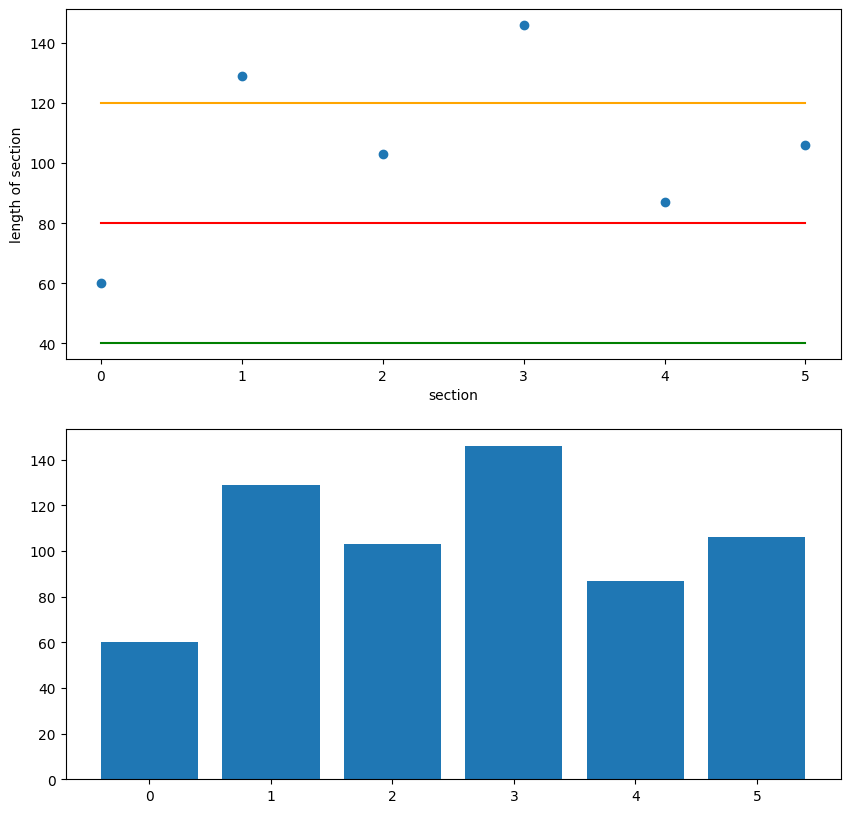

In [ ]:
# Initialize the section index and length of section lists
sec_index = []
len_text = []

# Iterate through section_dict_kp keys and append a sequential index starting from 0
for idx, section_key in enumerate(section_dict_kp.keys()):
    sec_index.append(idx)  # Append sequential index starting from 0
    len_text.append(len(section_dict_kp[section_key]))  # Append length of section content

print(sec_index)
print(len_text)

# Sum up the lengths of all sections
s = sum(len_text)
print(s)

# Define x_line based on sec_index range
x_line = [np.array(sec_index).min(), np.array(sec_index).max()]

# Fig
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Scatter plot
ax.scatter(x=sec_index, y=len_text)

# Plot threshold lines
ax.plot(x_line, [120, 120], color='orange')
ax.plot(x_line, [80, 80], color='red')
ax.plot(x_line, [40, 40], color='green')

ax.set_xlabel('section')
ax.set_ylabel('length of section')

# Uncomment to plot bars in second subplot if needed
ax2.bar(sec_index, height=len_text)

plt.show()


  First subplot: number of arguments per text. Lines are used to set the number of Keypoints to extract based on the distribution.
  - Below green line (40 arguments) we extract 3 kps
  - Between green-red (80 arguments) we extract 5 kps
  - Between red-yellow (120 arguments) we extract 7 kps
  - Above the yellow line (above 120 arguments) we extract 9 kps


In [ ]:
section_candidate={}
dict_grenzwert= {
    "<40":3,
    "40_80":5,
    "80_120":7,
    ">120":9
} #this dictonnary won't be used for now and just for visibility and the down sections repetition can be avoided but like this is clearly for the reader
for i in section_dict_kp.keys():
    l_text=len(section_dict_kp[i])
    if l_text <40:
      ranked_sents_temp = apply_page_rank(section_dict_kp[i], p=0.2, min_match_score=0.5)
      ranked_kps_temp = filter_ranked_list(ranked_sents_temp, model, min_match=0.6, N=dict_grenzwert['<40']) # decreased the min math to ensure a higher contextuel coverage
      section_candidate[i+ 'kp']=ranked_kps_temp
    elif l_text>39 and l_text < 80:
       ranked_sents_temp = apply_page_rank(section_dict_kp[i], p=0.2, min_match_score=0.5)
       ranked_kps_temp = filter_ranked_list(ranked_sents_temp, model, min_match=0.8, N=dict_grenzwert['40_80'])
       section_candidate[i+ 'kp']=ranked_kps_temp
    elif l_text>79 and l_text < 120:
       ranked_sents_temp = apply_page_rank(section_dict_kp[i], p=0.2, min_match_score=0.5)
       ranked_kps_temp = filter_ranked_list(ranked_sents_temp, model, min_match=0.8, N=dict_grenzwert['80_120'])
       section_candidate[i+ 'kp']=ranked_kps_temp
    else:
      ranked_sents_temp = apply_page_rank(section_dict_kp[i], p=0.2, min_match_score=0.5)
      ranked_kps_temp = filter_ranked_list(ranked_sents_temp, model, min_match=0.8, N=dict_grenzwert['>120'])
      section_candidate[i+ 'kp']=ranked_kps_temp


/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)
/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)
/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)
/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)
/usr/local/lib/python3.10/dist-packages/fast_pagerank/fast_pagerank.py:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)
/usr/local/lib/

In [ ]:
# Extract the data into a list of dictionaries for easier CSV conversion
output_data = []

for key, keypoints in section_candidate.items():
    # Split the key back into topic and stance
    split_key = key.split("_stance_")
    topic = split_key[0].replace("topic ", "")  # Remove 'topic ' prefix
    stance = split_key[1].replace("kp", "")     # Remove 'kp' suffix

    # Add each keypoint as a separate row
    for kp in keypoints:
        output_data.append({"key_point_predicted": kp, "topic": topic, "stance": stance})

# Create a DataFrame from the extracted data
output_df = pd.DataFrame(output_data)

# Save to CSV
output_df.to_csv("extracted_keypoints.csv", index=False)


#Evaluae with Rouge 1,2,L  with the reference keypoints

# Text preprocessing (stemming, cleaning, get predictions and references lists

In [ ]:
__cases = dict()
__cases["ΦΑΓΙΑ"] = "ΦΑ"
__cases["ΦΑΓΙΟΥ"] = "ΦΑ"
__cases["ΦΑΓΙΩΝ"] = "ΦΑ"
__cases["ΣΚΑΓΙΑ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΟΥ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΩΝ"] = "ΣΚΑ"
__cases["ΟΛΟΓΙΟΥ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΑ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΩΝ"] = "ΟΛΟ"
__cases["ΣΟΓΙΟΥ"] = "ΣΟ"
__cases["ΣΟΓΙΑ"] = "ΣΟ"
__cases["ΣΟΓΙΩΝ"] = "ΣΟ"
__cases["ΤΑΤΟΓΙΑ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΟΥ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΩΝ"] = "ΤΑΤΟ"
__cases["ΚΡΕΑΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΟΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΑ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΩΝ"] = "ΚΡΕ"
__cases["ΠΕΡΑΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΟΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΑ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΩΝ"] = "ΠΕΡ"
__cases["ΤΕΡΑΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΟΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΑ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΩΝ"] = "ΤΕΡ"
__cases["ΦΩΣ"] = "ΦΩ"
__cases["ΦΩΤΟΣ"] = "ΦΩ"
__cases["ΦΩΤΑ"] = "ΦΩ"
__cases["ΦΩΤΩΝ"] = "ΦΩ"
__cases["ΚΑΘΕΣΤΩΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΟΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΑ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΩΝ"] = "ΚΑΘΕΣΤ"
__cases["ΓΕΓΟΝΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΑ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΩΝ"] = "ΓΕΓΟΝ"
__vowels = "[ΑΕΗΙΟΥΩ]"
__refinedVowels = "[ΑΕΗΙΟΩ]"


def stemWord(w: str, exceptions: dict = None):
    stem = None
    suffix = None
    test1 = True

    if exceptions is not None and w in exceptions.keys():
        return exceptions[w]

    if len(w) < 4:
        return w

    pattern = None
    pattern2 = None
    pattern3 = None
    pattern4 = None

    # Step1
    pattern = re.compile(
        r"(.*)(ΦΑΓΙΑ|ΦΑΓΙΟΥ|ΦΑΓΙΩΝ|ΣΚΑΓΙΑ|ΣΚΑΓΙΟΥ|ΣΚΑΓΙΩΝ|ΟΛΟΓΙΟΥ|ΟΛΟΓΙΑ|ΟΛΟΓΙΩΝ|ΣΟΓΙΟΥ|ΣΟΓΙΑ|ΣΟΓΙΩΝ|ΤΑΤΟΓΙΑ|ΤΑΤΟΓΙΟΥ|ΤΑΤΟΓΙΩΝ|ΚΡΕΑΣ|ΚΡΕΑΤΟΣ|ΚΡΕΑΤΑ|ΚΡΕΑΤΩΝ|ΠΕΡΑΣ|ΠΕΡΑΤΟΣ|ΠΕΡΑΤΑ|ΠΕΡΑΤΩΝ|ΤΕΡΑΣ|ΤΕΡΑΤΟΣ|ΤΕΡΑΤΑ|ΤΕΡΑΤΩΝ|ΦΩΣ|ΦΩΤΟΣ|ΦΩΤΑ|ΦΩΤΩΝ|ΚΑΘΕΣΤΩΣ|ΚΑΘΕΣΤΩΤΟΣ|ΚΑΘΕΣΤΩΤΑ|ΚΑΘΕΣΤΩΤΩΝ|ΓΕΓΟΝΟΣ|ΓΕΓΟΝΟΤΟΣ|ΓΕΓΟΝΟΤΑ|ΓΕΓΟΝΟΤΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        suffix = fp[1]
        w = stem + __cases[suffix]
        test1 = False

    # Step 2a
    pattern = re.compile(r"^(.+?)(ΑΔΕΣ|ΑΔΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        reg1 = re.compile(r"(ΟΚ|ΜΑΜ|ΜΑΝ|ΜΠΑΜΠ|ΠΑΤΕΡ|ΓΙΑΓΙ|ΝΤΑΝΤ|ΚΥΡ|ΘΕΙ|ΠΕΘΕΡ)$")

        if not reg1.match(w):
            w = w + "ΑΔ"

    # Step 2b
    pattern2 = re.compile(r"^(.+?)(ΕΔΕΣ|ΕΔΩΝ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        except2 = re.compile(r"(ΟΠ|ΙΠ|ΕΜΠ|ΥΠ|ΓΗΠ|ΔΑΠ|ΚΡΑΣΠ|ΜΙΛ)$")
        if except2.match(w):
            w = w + "ΕΔ"

    # Step 2c
    pattern3 = re.compile(r"^(.+?)(ΟΥΔΕΣ|ΟΥΔΩΝ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        except3 = re.compile(r"(ΑΡΚ|ΚΑΛΙΑΚ|ΠΕΤΑΛ|ΛΙΧ|ΠΛΕΞ|ΣΚ|Σ|ΦΛ|ΦΡ|ΒΕΛ|ΛΟΥΛ|ΧΝ|ΣΠ|ΤΡΑΓ|ΦΕ)$")
        if except3.match(w):
            w = w + "ΟΥΔ"

    # Step 2d
    pattern4 = re.compile("^(.+?)(ΕΩΣ|ΕΩΝ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except4 = re.compile(r"^(Θ|Δ|ΕΛ|ΓΑΛ|Ν|Π|ΙΔ|ΠΑΡ)$")
        if except4.match(w):
            w = w + "Ε"

    # Step 3
    pattern = re.compile(r"^(.+?)(ΙΑ|ΙΟΥ|ΙΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        pattern2 = re.compile(__vowels + "$")
        test1 = False
        if pattern2.match(w):
            w = stem + "Ι"

    # Step 4
    pattern = re.compile(r"^(.+?)(ΙΚΑ|ΙΚΟ|ΙΚΟΥ|ΙΚΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__vowels + "$")
        except5 = re.compile(
            r"^(ΑΛ|ΑΔ|ΕΝΔ|ΑΜΑΝ|ΑΜΜΟΧΑΛ|ΗΘ|ΑΝΗΘ|ΑΝΤΙΔ|ΦΥΣ|ΒΡΩΜ|ΓΕΡ|ΕΞΩΔ|ΚΑΛΠ|ΚΑΛΛΙΝ|ΚΑΤΑΔ|ΜΟΥΛ|ΜΠΑΝ|ΜΠΑΓΙΑΤ|ΜΠΟΛ|ΜΠΟΣ|ΝΙΤ|ΞΙΚ|ΣΥΝΟΜΗΛ|ΠΕΤΣ|ΠΙΤΣ|ΠΙΚΑΝΤ|ΠΛΙΑΤΣ|ΠΟΣΤΕΛΝ|ΠΡΩΤΟΔ|ΣΕΡΤ|ΣΥΝΑΔ|ΤΣΑΜ|ΥΠΟΔ|ΦΙΛΟΝ|ΦΥΛΟΔ|ΧΑΣ)$")
        if except5.match(w) or pattern2.match(w):
            w = w + "ΙΚ"

    # step 5a
    pattern = re.compile(r"^(.+?)(ΑΜΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΑΓΑΜΕ|ΗΣΑΜΕ|ΟΥΣΑΜΕ|ΗΚΑΜΕ|ΗΘΗΚΑΜΕ)$")
    if w == "ΑΓΑΜΕ":
        w = "ΑΓΑΜ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except6 = re.compile(r"^(ΑΝΑΠ|ΑΠΟΘ|ΑΠΟΚ|ΑΠΟΣΤ|ΒΟΥΒ|ΞΕΘ|ΟΥΛ|ΠΕΘ|ΠΙΚΡ|ΠΟΤ|ΣΙΧ|Χ)$")
        if except6.match(w):
            w = w + "ΑΜ"

    # Step 5b
    pattern2 = re.compile(r"^(.+?)(ΑΝΕ)$")
    pattern3 = re.compile(r"^(.+?)(ΑΓΑΝΕ|ΗΣΑΝΕ|ΟΥΣΑΝΕ|ΙΟΝΤΑΝΕ|ΙΟΤΑΝΕ|ΙΟΥΝΤΑΝΕ|ΟΝΤΑΝΕ|ΟΤΑΝΕ|ΟΥΝΤΑΝΕ|ΗΚΑΝΕ|ΗΘΗΚΑΝΕ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(r"^(ΤΡ|ΤΣ)$")
        if pattern3.match(w):
            w = w + "ΑΓΑΝ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__refinedVowels + "$")
        except7 = re.compile(
            r"^(ΒΕΤΕΡ|ΒΟΥΛΚ|ΒΡΑΧΜ|Γ|ΔΡΑΔΟΥΜ|Θ|ΚΑΛΠΟΥΖ|ΚΑΣΤΕΛ|ΚΟΡΜΟΡ|ΛΑΟΠΛ|ΜΩΑΜΕΘ|Μ|ΜΟΥΣΟΥΛΜ|Ν|ΟΥΛ|Π|ΠΕΛΕΚ|ΠΛ|ΠΟΛΙΣ|ΠΟΡΤΟΛ|ΣΑΡΑΚΑΤΣ|ΣΟΥΛΤ|ΤΣΑΡΛΑΤ|ΟΡΦ|ΤΣΙΓΓ|ΤΣΟΠ|ΦΩΤΟΣΤΕΦ|Χ|ΨΥΧΟΠΛ|ΑΓ|ΟΡΦ|ΓΑΛ|ΓΕΡ|ΔΕΚ|ΔΙΠΛ|ΑΜΕΡΙΚΑΝ|ΟΥΡ|ΠΙΘ|ΠΟΥΡΙΤ|Σ|ΖΩΝΤ|ΙΚ|ΚΑΣΤ|ΚΟΠ|ΛΙΧ|ΛΟΥΘΗΡ|ΜΑΙΝΤ|ΜΕΛ|ΣΙΓ|ΣΠ|ΣΤΕΓ|ΤΡΑΓ|ΤΣΑΓ|Φ|ΕΡ|ΑΔΑΠ|ΑΘΙΓΓ|ΑΜΗΧ|ΑΝΙΚ|ΑΝΟΡΓ|ΑΠΗΓ|ΑΠΙΘ|ΑΤΣΙΓΓ|ΒΑΣ|ΒΑΣΚ|ΒΑΘΥΓΑΛ|ΒΙΟΜΗΧ|ΒΡΑΧΥΚ|ΔΙΑΤ|ΔΙΑΦ|ΕΝΟΡΓ|ΘΥΣ|ΚΑΠΝΟΒΙΟΜΗΧ|ΚΑΤΑΓΑΛ|ΚΛΙΒ|ΚΟΙΛΑΡΦ|ΛΙΒ|ΜΕΓΛΟΒΙΟΜΗΧ|ΜΙΚΡΟΒΙΟΜΗΧ|ΝΤΑΒ|ΞΗΡΟΚΛΙΒ|ΟΛΙΓΟΔΑΜ|ΟΛΟΓΑΛ|ΠΕΝΤΑΡΦ|ΠΕΡΗΦ|ΠΕΡΙΤΡ|ΠΛΑΤ|ΠΟΛΥΔΑΠ|ΠΟΛΥΜΗΧ|ΣΤΕΦ|ΤΑΒ|ΤΕΤ|ΥΠΕΡΗΦ|ΥΠΟΚΟΠ|ΧΑΜΗΛΟΔΑΠ|ΨΗΛΟΤΑΒ)$")
        if (pattern2.match(w)) or (except7.match(w)):
            w = w + "ΑΝ"

    # //Step 5c
    pattern3 = re.compile(r"^(.+?)(ΕΤΕ)$")
    pattern4 = re.compile(r"^(.+?)(ΗΣΕΤΕ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(__refinedVowels + "$")
        except8 = re.compile(
            r"(ΟΔ|ΑΙΡ|ΦΟΡ|ΤΑΘ|ΔΙΑΘ|ΣΧ|ΕΝΔ|ΕΥΡ|ΤΙΘ|ΥΠΕΡΘ|ΡΑΘ|ΕΝΘ|ΡΟΘ|ΣΘ|ΠΥΡ|ΑΙΝ|ΣΥΝΔ|ΣΥΝ|ΣΥΝΘ|ΧΩΡ|ΠΟΝ|ΒΡ|ΚΑΘ|ΕΥΘ|ΕΚΘ|ΝΕΤ|ΡΟΝ|ΑΡΚ|ΒΑΡ|ΒΟΛ|ΩΦΕΛ)$")
        except9 = re.compile(
            r"^(ΑΒΑΡ|ΒΕΝ|ΕΝΑΡ|ΑΒΡ|ΑΔ|ΑΘ|ΑΝ|ΑΠΛ|ΒΑΡΟΝ|ΝΤΡ|ΣΚ|ΚΟΠ|ΜΠΟΡ|ΝΙΦ|ΠΑΓ|ΠΑΡΑΚΑΛ|ΣΕΡΠ|ΣΚΕΛ|ΣΥΡΦ|ΤΟΚ|Υ|Δ|ΕΜ|ΘΑΡΡ|Θ)$")
        if (pattern3.match(w)) or (except8.match(w)) or (except9.match(w)):
            w = w + "ΕΤ"

    # Step 5d
    pattern = re.compile(r"^(.+?)(ΟΝΤΑΣ|ΩΝΤΑΣ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except10 = re.compile(r"^(ΑΡΧ)$")
        except11 = re.compile(r"(ΚΡΕ)$")
        if except10.match(w):
            w = w + "ΟΝΤ"
        if except11.match(w):
            w = w + "ΩΝΤ"

    # Step 5e
    pattern = re.compile(r"^(.+?)(ΟΜΑΣΤΕ|ΙΟΜΑΣΤΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except11 = re.compile("^(ΟΝ)$")
        if except11.match(w):
            w = w + "ΟΜΑΣΤ"

    # Step 5f
    pattern = re.compile(r"^(.+?)(ΕΣΤΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΙΕΣΤΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(r"^(Π|ΑΠ|ΣΥΜΠ|ΑΣΥΜΠ|ΑΚΑΤΑΠ|ΑΜΕΤΑΜΦ)$")
        if pattern2.match(w):
            w = w + "ΙΕΣΤ"

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except12 = re.compile(r"^(ΑΛ|ΑΡ|ΕΚΤΕΛ|Ζ|Μ|Ξ|ΠΑΡΑΚΑΛ|ΑΡ|ΠΡΟ|ΝΙΣ)$")
        if except12.match(w):
            w = w + "ΕΣΤ"

    # Step 5g
    pattern = re.compile(r"^(.+?)(ΗΚΑ|ΗΚΕΣ|ΗΚΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΗΘΗΚΑ|ΗΘΗΚΕΣ|ΗΘΗΚΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except13 = re.compile(r"(ΣΚΩΛ|ΣΚΟΥΛ|ΝΑΡΘ|ΣΦ|ΟΘ|ΠΙΘ)$")
        except14 = re.compile(r"^(ΔΙΑΘ|Θ|ΠΑΡΑΚΑΤΑΘ|ΠΡΟΣΘ|ΣΥΝΘ|)$")
        if (except13.match(w)) or (except14.match(w)):
            w = w + "ΗΚ"

    # Step 5h
    pattern = re.compile(r"^(.+?)(ΟΥΣΑ|ΟΥΣΕΣ|ΟΥΣΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except15 = re.compile(
            r"^(ΦΑΡΜΑΚ|ΧΑΔ|ΑΓΚ|ΑΝΑΡΡ|ΒΡΟΜ|ΕΚΛΙΠ|ΛΑΜΠΙΔ|ΛΕΧ|Μ|ΠΑΤ|Ρ|Λ|ΜΕΔ|ΜΕΣΑΖ|ΥΠΟΤΕΙΝ|ΑΜ|ΑΙΘ|ΑΝΗΚ|ΔΕΣΠΟΖ|ΕΝΔΙΑΦΕΡ|ΔΕ|ΔΕΥΤΕΡΕΥ|ΚΑΘΑΡΕΥ|ΠΛΕ|ΤΣΑ)$")
        except16 = re.compile(r"(ΠΟΔΑΡ|ΒΛΕΠ|ΠΑΝΤΑΧ|ΦΡΥΔ|ΜΑΝΤΙΛ|ΜΑΛΛ|ΚΥΜΑΤ|ΛΑΧ|ΛΗΓ|ΦΑΓ|ΟΜ|ΠΡΩΤ)$")
        if (except15.match(w)) or (except16.match(w)):
            w = w + "ΟΥΣ"

    # Step 5i
    pattern = re.compile(r"^(.+?)(ΑΓΑ|ΑΓΕΣ|ΑΓΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except17 = re.compile(r"^(ΨΟΦ|ΝΑΥΛΟΧ)$")
        except20 = re.compile(r"(ΚΟΛΛ)$")
        except18 = re.compile(
            r"^(ΑΒΑΣΤ|ΠΟΛΥΦ|ΑΔΗΦ|ΠΑΜΦ|Ρ|ΑΣΠ|ΑΦ|ΑΜΑΛ|ΑΜΑΛΛΙ|ΑΝΥΣΤ|ΑΠΕΡ|ΑΣΠΑΡ|ΑΧΑΡ|ΔΕΡΒΕΝ|ΔΡΟΣΟΠ|ΞΕΦ|ΝΕΟΠ|ΝΟΜΟΤ|ΟΛΟΠ|ΟΜΟΤ|ΠΡΟΣΤ|ΠΡΟΣΩΠΟΠ|ΣΥΜΠ|ΣΥΝΤ|Τ|ΥΠΟΤ|ΧΑΡ|ΑΕΙΠ|ΑΙΜΟΣΤ|ΑΝΥΠ|ΑΠΟΤ|ΑΡΤΙΠ|ΔΙΑΤ|ΕΝ|ΕΠΙΤ|ΚΡΟΚΑΛΟΠ|ΣΙΔΗΡΟΠ|Λ|ΝΑΥ|ΟΥΛΑΜ|ΟΥΡ|Π|ΤΡ|Μ)$")
        except19 = re.compile(r"(ΟΦ|ΠΕΛ|ΧΟΡΤ|ΛΛ|ΣΦ|ΡΠ|ΦΡ|ΠΡ|ΛΟΧ|ΣΜΗΝ)$")
        if (except18.match(w) and except19.match(w)) and not ((except17.match(w)) or (except20.match(w))):
            w = w + "ΑΓ"

    # Step 5j
    pattern = re.compile("^(.+?)(ΗΣΕ|ΗΣΟΥ|ΗΣΑ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except21 = re.compile(r"^(Ν|ΧΕΡΣΟΝ|ΔΩΔΕΚΑΝ|ΕΡΗΜΟΝ|ΜΕΓΑΛΟΝ|ΕΠΤΑΝ)$")
        if except21.match(w):
            w = w + "ΗΣ"

    # Step 5k
    pattern = re.compile(r"^(.+?)(ΗΣΤΕ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except22 = re.compile(r"^(ΑΣΒ|ΣΒ|ΑΧΡ|ΧΡ|ΑΠΛ|ΑΕΙΜΝ|ΔΥΣΧΡ|ΕΥΧΡ|ΚΟΙΝΟΧΡ|ΠΑΛΙΜΨ)$")
        if except22.match(w):
            w = w + "ΗΣΤ"

    # Step 5l
    pattern = re.compile("^(.+?)(ΟΥΝΕ|ΗΣΟΥΝΕ|ΗΘΟΥΝΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except23 = re.compile("^(Ν|Ρ|ΣΠΙ|ΣΤΡΑΒΟΜΟΥΤΣ|ΚΑΚΟΜΟΥΤΣ|ΕΞΩΝ)$")
        if except23.match(w):
            w = w + "ΟΥΝ"

    # Step 5l
    pattern = re.compile(r"^(.+?)(ΟΥΜΕ|ΗΣΟΥΜΕ|ΗΘΟΥΜΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except24 = re.compile(r"^(ΠΑΡΑΣΟΥΣ|Φ|Χ|ΩΡΙΟΠΛ|ΑΖ|ΑΛΛΟΣΟΥΣ|ΑΣΟΥΣ)$")
        if except24.match(w):
            w = w + "ΟΥΜ"

    # Step 6
    pattern = re.compile(r"^(.+?)(ΜΑΤΑ|ΜΑΤΩΝ|ΜΑΤΟΣ)$")
    pattern2 = re.compile(
        r"^(.+?)(Α|ΑΓΑΤΕ|ΑΓΑΝ|ΑΕΙ|ΑΜΑΙ|ΑΝ|ΑΣ|ΑΣΑΙ|ΑΤΑΙ|ΑΩ|Ε|ΕΙ|ΕΙΣ|ΕΙΤΕ|ΕΣΑΙ|ΕΣ|ΕΤΑΙ|Ι|ΙΕΜΑΙ|ΙΕΜΑΣΤΕ|ΙΕΤΑΙ|ΙΕΣΑΙ|ΙΕΣΑΣΤΕ|ΙΟΜΑΣΤΑΝ|ΙΟΜΟΥΝ|ΙΟΜΟΥΝΑ|ΙΟΝΤΑΝ|ΙΟΝΤΟΥΣΑΝ|ΙΟΣΑΣΤΑΝ|ΙΟΣΑΣΤΕ|ΙΟΣΟΥΝ|ΙΟΣΟΥΝΑ|ΙΟΤΑΝ|ΙΟΥΜΑ|ΙΟΥΜΑΣΤΕ|ΙΟΥΝΤΑΙ|ΙΟΥΝΤΑΝ|Η|ΗΔΕΣ|ΗΔΩΝ|ΗΘΕΙ|ΗΘΕΙΣ|ΗΘΕΙΤΕ|ΗΘΗΚΑΤΕ|ΗΘΗΚΑΝ|ΗΘΟΥΝ|ΗΘΩ|ΗΚΑΤΕ|ΗΚΑΝ|ΗΣ|ΗΣΑΝ|ΗΣΑΤΕ|ΗΣΕΙ|ΗΣΕΣ|ΗΣΟΥΝ|ΗΣΩ|Ο|ΟΙ|ΟΜΑΙ|ΟΜΑΣΤΑΝ|ΟΜΟΥΝ|ΟΜΟΥΝΑ|ΟΝΤΑΙ|ΟΝΤΑΝ|ΟΝΤΟΥΣΑΝ|ΟΣ|ΟΣΑΣΤΑΝ|ΟΣΑΣΤΕ|ΟΣΟΥΝ|ΟΣΟΥΝΑ|ΟΤΑΝ|ΟΥ|ΟΥΜΑΙ|ΟΥΜΑΣΤΕ|ΟΥΝ|ΟΥΝΤΑΙ|ΟΥΝΤΑΝ|ΟΥΣ|ΟΥΣΑΝ|ΟΥΣΑΤΕ|Υ|ΥΣ|Ω|ΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem + "ΜΑ"

    if pattern2.match(w) and test1:
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem

    # Step 7 (ΠΑΡΑΘΕΤΙΚΑ)
    pattern = re.compile(r"^(.+?)(ΕΣΤΕΡ|ΕΣΤΑΤ|ΟΤΕΡ|ΟΤΑΤ|ΥΤΕΡ|ΥΤΑΤ|ΩΤΕΡ|ΩΤΑΤ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem

    return w

# Notes:
# (1) Greek word to get stemmed should be in capital letters and without accents. E.g. ΨΩΜΙ and not Ψωμί
# (2) Any word of length 1 - 3 will not get stemmed.
# (3) The exceptions argument is a dictionary where a key is a word and a value is a custom stem of your liking

In [ ]:
def replaceMultiple(main, replacements, new):
  for elem in replacements:
    if elem in main:
      main = main.replace(elem, new)
  return main

def normalize(x):
  x = replaceMultiple(x, ['ά', 'ὰ', 'ἀ','ἁ','ἂ','ἃ','ἄ','ἅ','ἆ','ἇ','ᾰ','ᾱ','ᾲ','ᾳ','ᾴ','ᾶ','ᾷ'], 'α')
  x = replaceMultiple(x, ['έ','ὲ','ἐ','ἑ','ἒ','ἓ','ἔ','ἕ'], 'ε')
  x = replaceMultiple(x, ['ή','ὴ','ἠ','ἡ','ἢ','ἣ','ἤ','ἥ','ἦ','ἧ','ῂ','ῃ','ῄ','ῆ','ῇ'], 'η')
  x = replaceMultiple(x, ['ί','ὶ','ἰ','ἱ','ἲ','ἳ','ἴ','ἵ','ἶ','ἷ','ῐ','ῑ','ῒ','ΐ','ῖ','ῗ'], 'ι')
  x = replaceMultiple(x, ['ὸ','ό','ὀ','ὁ','ὂ','ὃ','ὄ','ὅ'], 'ο')
  x = replaceMultiple(x, ['ύ','ὺ','ΰ', 'ϋ','ὐ','ὑ','ὒ','ὓ','ὔ','ὕ','ὖ','ὗ','ῠ','ῡ','ῢ','ΰ','ῦ'], 'υ')
  x = replaceMultiple(x, ['ώ','ὼ','ῶ','ῲ','ῳ','ῴ','ῶ','ῷ','ὠ','ὡ','ὢ','ὣ','ὤ','ὥ','ὦ','ὧ'], 'ω')
  return x

def remove_emojis(text):
    return demoji.replace(text, '')

def sep_punc(x):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~؛،؟؛.»«”'
    out = []
    for char in x:
        if char in punc:
            out.append(' ' + char + ' ')
        else:
            out.append(char)
    return ''.join(out)

def preprocess_text(text):
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    text = text.lower()
    text=normalize(text)
     # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{''.join(re.escape(c) for c in string.punctuation if c != '_') }]", ' ', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
  # Remove words with character length equal to or less than 1
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    text = ' '.join(filtered_words)
    text = remove_emojis(text)
    text = str(text).upper().strip()
    tokenized_tweet = word_tokenize(text)
    tokenized_tweet = [stemWord(i) for i in tokenized_tweet]
    return ' '.join(tokenized_tweet)

In [ ]:
pd.set_option("display.max_colwidth", None)

def preprocess_dataset(pred_df, ref_df):
    # Dynamically extract unique topics and stances from the pred_df
    topics = pred_df['topic'].unique()
    stances = pred_df['stance'].unique()

    predictions, references = [], []

    for topic in topics:
        for stance in stances:
            # Filter predicted keypoints from pred_df based on dynamic topic and stance
            kps = pred_df.loc[(pred_df['topic'] == topic) & (pred_df['stance'] == stance), 'key_point_predicted'].tolist()

            # Filter reference keypoints from ref_df based on dynamic topic and stance
            gold_kps = ref_df.loc[(ref_df['topic'] == topic) & (ref_df['stance'] == stance), 'key_point'].tolist()

            predictions.append(kps)
            references.append(gold_kps)

    return predictions, references




#Rouge computation

In [ ]:
# Function to compute Rouge scores using evaluate's rouge.compute() per topic
def compute_rouge(predictions, references):
    # Load the Rouge metric from the evaluate library
    rouge = load('rouge')

    rouge1_scores, rouge2_scores, rougel_scores = [], [], []

    for preds, refs in zip(predictions, references):
        # Compute per topic average scores on all unique combinations of generated keypoints and ground-truth
        r_1, r_2, r_l = [], [], []
        # Preprocess the predicted keypoints and reference keypoints
        preds = [preprocess_text(pred) for pred in preds]
        refs = [preprocess_text(ref) for ref in refs]
        for a, b in product(preds, refs):
            # Use the evaluate library's rouge.compute() function to get the scores for each keypoint pair
            rouge_scores = rouge.compute(predictions=[a], references=[b], tokenizer=lambda x: x.split())

            # Since the values are floats, no need to access 'fmeasure'
            r_1.append(round(rouge_scores['rouge1'], 3))
            r_2.append(round(rouge_scores['rouge2'], 3))
            r_l.append(round(rouge_scores['rougeL'], 3))

        # Save per topic scores to compute average over all topics as the final score
        rouge1_scores.append(round(mean(r_1), 3))
        rouge2_scores.append(round(mean(r_2), 3))
        rougel_scores.append(round(mean(r_l), 3))

    # Print the average scores across all topics
    print("Rouge 1: {}".format(round(mean(rouge1_scores), 3)))
    print("Rouge 2: {}".format(round(mean(rouge2_scores), 3)))
    print("Rouge L: {}".format(round(mean(rougel_scores), 3)))


def compute_bertscore(predictions, references):
    bertscore_metric = load('bertscore')

    bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], []

    for preds, refs in zip(predictions, references):
        # Compute per-topic average scores on all unique combinations of generated keypoints and ground-truth
        r_1, r_2, r_l = [], [], []
        bert_prec, bert_recall, bert_f1 = [], [], []


        # Compute Rouge Scores
        for a, b in product(preds, refs):
            # Compute BERTScore without preprocessing
            bertscore_result = bertscore_metric.compute(predictions=[a], references=[b], lang="el")
            bert_prec.append(round(bertscore_result['precision'][0], 3))
            bert_recall.append(round(bertscore_result['recall'][0], 3))
            bert_f1.append(round(bertscore_result['f1'][0], 3))


        # Save per-topic BERTScore to compute average over all topics as the final score
        bertscore_precisions.append(round(mean(bert_prec), 3))
        bertscore_recalls.append(round(mean(bert_recall), 3))
        bertscore_f1s.append(round(mean(bert_f1), 3))

    # Print the average BERTScore scores across all topics
    print("BERTScore Precision: {}".format(round(mean(bertscore_precisions), 3)))
    print("BERTScore Recall: {}".format(round(mean(bertscore_recalls), 3)))
    print("BERTScore F1: {}".format(round(mean(bertscore_f1s), 3)))


In [ ]:
# Load your DataFrames
pred_df = pd.read_csv('/content/extracted_keypoints.csv')
ref_df = pd.read_csv('/content/gdrive/MyDrive/Πτυχιακή/Code/Experiments_Meltemi/train_dev_test_dataset/key_points_human_translated_test.csv')

In [ ]:
pred_df.columns

Index(['key_point_predicted', 'topic', 'stance'], dtype='object')

In [ ]:
predictions, references = preprocess_dataset(pred_df, ref_df)
print(predictions[0])
print(references[0])
compute_rouge(predictions, references)

['Οι άνισοι τρόποι ζωής σημαίνουν ότι υπάρχει τόση αναταραχή στις ΗΠΑ, που δεν είναι μια καλή χώρα να ζει κανείς.', 'Οι ΗΠΑ δεν είναι μια καλή χώρα για να ζει κανείς, επειδή υπάρχει πάρα πολύς κυβερνητικός έλεγχος.', 'Οι ΗΠΑ δεν είναι μια καλή χώρα για να ζει κανείς, επειδή εκεί πολλοί άνθρωποι είναι ρατσιστές', 'Οι ΗΠΑ δεν είναι μια καλή χώρα για να ζει κανείς, υπάρχει πολύς κίνδυνος λόγω της έλλειψης κανονισμών για τα όπλα', 'Στην χώρα αυτή αντιμετωπίζει κανείς πολλές διακρίσεις σε όλους τους τομείς, και αυτό το θέμα της εργασίας επηρεάζει πολύ τους πολίτες.']
['Οι Ηνωμένες Πολιτείες έχουν άδικες πολιτικές στους τομείς της υγείας και της εκπαίδευσης', 'Οι Ηνωμένες Πολιτείες έχουν ένα προβληματικό/διχαστικό πολιτικό σύστημα', 'Οι Ηνωμένες Πολιτείες έχουν υψηλή φορολογία και υψηλό κόστος διαβίωσης', 'Στις Ηνωμένες Πολιτείες υπάρχει ξενοφοβία και ρατσισμός', 'Οι Ηνωμένες Πολιτείες έχουν ανισότητες και φτώχεια', 'Στις Ηνωμένες Πολιτείες δεν υπάρχει ασφάλεια', 'Στις Ηνωμένες Πολιτείες υπά

Rouge 1: 0.131
Rouge 2: 0.034
Rouge L: 0.116


In [ ]:
compute_bertscore(predictions, references)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore Precision: 0.678
BERTScore Recall: 0.697
BERTScore F1: 0.687
